In [15]:
import os
import time
import shutil
import numpy as np
from tqdm import tqdm
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.animation as animation

# Fitness Function

In [16]:
def fitness_repel(firsts, idx, p_ij, Dmin=1):
    distances = np.linalg.norm(firsts - p_ij, axis=1)
    distances[idx] = np.inf # 排除自身
    nnd = np.min(distances)
    return np.exp(2 * (Dmin - nnd)) if nnd < Dmin else 1
    
def fitness_closure(firsts, idx, p_ij, prey):
    firsts[idx] = p_ij # 替换为虚拟robot
    try:
        hull = ConvexHull(firsts)
    except Exception as e:
        return 1
    hull_vertices = firsts[hull.vertices]
    hull_path = Path(hull_vertices)
    if hull_path.contains_point(prey): # 判断是否在凸包内部
        return 0
    def is_point_on_segment(point, p1, p2):
        v1 = point - p1
        v2 = point - p2
        if np.cross(np.append(v1, [0]), np.append(v2, [0]))[-1] == 0:  # 点在直线上
            if v1[0] * v2[0] <= 0 and v1[1] * v2[1] <= 0:  # 点在线段上
                return True
        return False
    for i in range(len(hull_vertices)):
        p1 = hull_vertices[i]
        p2 = hull_vertices[(i+1) % len(hull_vertices)]
        if is_point_on_segment(prey, p1, p2): # 判断是否凸包边界上
            return 0.5
    return 1

def fitness_expanse(firsts, idx, p_ij, prey):
    firsts[idx] = p_ij # 替换为虚拟robot
    return np.sum(np.linalg.norm(firsts - prey, axis=1)) / len(firsts)

def fitness_uniformity(firsts, idx, p_ij, prey):
    firsts[idx] = p_ij # 替换为虚拟robot
    mask11 = (firsts[:, 0] < prey[0]) & (firsts[:, 1] >= prey[1])
    mask12 = (firsts[:, 0] >= prey[0]) & (firsts[:, 1] > prey[1])
    mask21 = (firsts[:, 0] <= prey[0]) & (firsts[:, 1] < prey[1])
    mask22 = (firsts[:, 0] > prey[0]) & (firsts[:, 1] <= prey[1])
    std = np.std(np.array([sum(mask11), sum(mask12), sum(mask21), sum(mask22)]))
    return std


# Iteration Based on PSO

In [ ]:
def ccpso(Ns=8, Np=20, left_range=-15, right_range=15, vicinity=3, time_lim=1000):
    
    start_time = time.time()
    p_robots = np.random.randint(left_range, right_range, (Ns, Np, 2)) # 初始种群
    p_individual = np.zeros((Ns, Np, 2), dtype=np.int32) # 历史最优位置
    p_group = np.zeros((Ns, 2), dtype=np.int32) # 组内最优位置
    v_robots = np.zeros((Ns, Np, 2), dtype=np.int32) # 速度
    f_robots = np.zeros((Ns, Np)) # 适应度
    f_individual = np.full((Ns, Np), np.inf) # 历史最优适应度
    f_group = np.full(Ns, np.inf) # 组内最优适应度
    
    prey = np.array([0, 0]) # 猎物位置
    captured = False
    
    SN = np.array([[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]])
    bound_angle = np.arctan2(SN[:, 1], SN[:, 0])
    
    # pso超参数
    w = 1
    c1 = 2
    c2 = 2
    Tv = 5
    
    def collide(pos):
        for robot in p_robots[:, 0]:
            if np.all(pos == robot):
                return True
        return np.all(pos == prey)
    
    def legal_steps(pos):
        steps = np.array([], dtype=np.int32)
        for step in SN[0::2]:
            target = pos + step
            if target[0] >= left_range and target[0] <= right_range and\
               target[1] >= left_range and target[1] <= right_range and\
               not collide(target):
                steps = np.append(steps, step)
        for step in SN[1::2]:
            target = pos + step
            hori = np.array([step[0], 0])
            vert = np.array([0, step[1]])
            if target[0] >= left_range and target[0] <= right_range and\
               target[1] >= left_range and target[1] <= right_range and\
               (not collide(target)) and not (collide(pos + hori) and collide(pos + vert)):
                steps = np.append(steps, step)
        return steps.reshape(-1, 2)
    
    def nnd(pos, v):
        steps = legal_steps(pos)
        if not len(steps):
            return np.array([0, 0])
        dot_products = np.dot(steps, v) / np.linalg.norm(steps, axis=1)
        index = np.argmax(dot_products)
        return steps[index]
        
    def evaluate(idx, j):
        f_repel = fitness_repel(p_robots[:, 0].copy(), idx, p_robots[idx, j])
        f_closure = fitness_closure(p_robots[:, 0].copy(), idx, p_robots[idx, j], prey)
        f_expanse = fitness_expanse(p_robots[:, 0].copy(), idx, p_robots[idx, j], prey)
        f_uniformity = fitness_uniformity(p_robots[:, 0].copy(), idx, p_robots[idx, j], prey)
        f_robots[idx, j] = f_repel * (f_closure + f_expanse + f_uniformity)
        if f_robots[idx, j] < f_individual[idx, j]:
            f_individual[idx, j] = f_robots[idx, j]
            p_individual[idx, j] = p_robots[idx, j]
    
    def update(idx):
        for j in range(1, Np):
            r1 = np.random.rand() * c1
            r2 = np.random.rand() * c2
            v = w * v_robots[idx, j] + r1 * (p_individual[idx, j] - p_robots[idx, j]) + r2 * (p_group[idx] - p_robots[idx, j])
            v_robots[idx, j] = nnd(p_robots[idx, j], v)
            
            p_ij = p_robots[idx, j] + v_robots[idx, j]
            if np.linalg.norm(p_ij - p_robots[idx, 0]) > vicinity:
                real_angle = np.arctan2(p_ij[1] - p_robots[idx, 0, 1], p_ij[0] - p_robots[idx, 0, 0])
                v = np.argmin(np.abs(bound_angle - real_angle))
                p_ij = p_robots[idx, 0] + vicinity * SN[v]
            
            p_robots[idx, j] = p_ij
            evaluate(idx, j)   
        f_group[idx] = np.min(f_robots[idx])
        p_group[idx] = p_robots[idx][np.argmin(f_robots[idx])]        
    
    # 创建画布
    fig, ax = plt.subplots()
    ax.set_xlim(left_range, right_range)
    ax.set_ylim(left_range, right_range)
    scatter_virtuals = ax.scatter([], [], c='lightgreen', marker='o', label='Virtual Robots', s=10)
    scatter_robots = ax.scatter([], [], c='blue', marker='s', label='Real Robots', s=20)
    scatter_prey = ax.scatter(prey[0], prey[1], c='red', marker='*', label='Prey', s=50)
    ax.legend(loc='upper right')
    frame_dir = 'frames'
    frame_cnt = 0
    os.makedirs(frame_dir, exist_ok=True)
    
    # 移动方向
    def direct(pos):
        center = np.average(p_robots[:, 0], axis=0)
        v = pos - center
        step = nnd(pos, v)
        return step               
    
    step = direct(prey)
    
    while time.time() - start_time < time_lim and not captured:
        
        steps = legal_steps(prey)
        if any(np.array_equal(step, s) for s in steps):
            # 方向可以走
            prey += step
        elif (prey[0] <= left_range or prey[0] >= right_range or prey[1] <= left_range or prey[1] >= right_range) and len(steps):
            # 撞边但有路
            step = direct(prey)
            prey += step
        elif len(steps):
            # 有路
            temp_step = direct(prey)
            prey += temp_step
        else:
            captured = True
            break
            
        for i in range(Ns):
            update(i)
            evaluate(i, 0)
            unique_cnt = np.unique(p_robots[i, 1:], axis=0).shape[0]
            if unique_cnt < Tv:
                p_robots[i, 1:] = np.random.randint(left_range, right_range, (Np - 1, 2))
                update(i)
            
            if f_group[i] < f_robots[i, 0]:
                v = p_group[i] - p_robots[i, 0]
                v_robots[i, 0] = nnd(p_robots[i, 0], v)
                p_robots[i, 0] += v_robots[i, 0]
                evaluate(i, 0)

        #TODO: 实现死锁检测
        
        scatter_virtuals.set_offsets(p_robots[:, 1:].reshape(-1, 2))
        scatter_robots.set_offsets(p_robots[:, 0])
        scatter_prey.set_offsets(prey)
        frame_path = os.path.join(frame_dir, f'frame_{frame_cnt:03d}.png')
        plt.savefig(frame_path)
        frame_cnt += 1

    plt.close(fig)
    fig, ax = plt.subplots()
    ax.axis('off')
    frames = []
    for i in range(frame_cnt):
        img = plt.imread(os.path.join(frame_dir, f'frame_{i:03d}.png'))
        frame = ax.imshow(img, animated=True)
        frames.append([frame])
    for i in range(5):
        frames.append([frame])
    ani = animation.ArtistAnimation(fig, frames, interval=100)
    ani_file = f'pso_animation_{right_range*2}_{Ns}.gif'
    ani.save(ani_file, writer='pillow', fps=3)
    shutil.rmtree(frame_dir)  # 删除整个文件夹
    return frame_cnt

# Iteration Based on BSO

In [ ]:
def ccbso(Ns=8, Np=20, left_range=-15, right_range=15, vicinity=10, time_lim=1000):
    
    start_time = time.time()
    p_robots = np.random.randint(left_range, right_range, (Ns, Np, 2)) # 初始种群
    p_group = np.zeros((Ns, 2), dtype=np.int32) # 组内最优位置
    v_robots = np.zeros((Ns, Np, 2), dtype=np.int32) # 速度
    f_robots = np.zeros((Ns, Np)) # 适应度
    f_group = np.full(Ns, np.inf) # 组内最优适应度
    
    prey = np.array([0, 0]) # 猎物位置
    captured = False
    
    SN = np.array([[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]])
    bound_angle = np.arctan2(SN[:, 1], SN[:, 0])
    
    # bso超参数
    singal_prob = 0.5
    keep_prob = 0.6
    
    def collide(pos):
        for robot in p_robots[:, 0]:
            if np.all(pos == robot):
                return True
        return np.all(pos == prey)
    
    def legal_steps(pos):
        steps = np.array([], dtype=np.int32)
        for step in SN[0::2]:
            target = pos + step
            if target[0] >= left_range and target[0] <= right_range and\
               target[1] >= left_range and target[1] <= right_range and\
               not collide(target):
                steps = np.append(steps, step)
        for step in SN[1::2]:
            target = pos + step
            hori = np.array([step[0], 0])
            vert = np.array([0, step[1]])
            if target[0] >= left_range and target[0] <= right_range and\
               target[1] >= left_range and target[1] <= right_range and\
               (not collide(target)) and not (collide(pos + hori) and collide(pos + vert)):
                steps = np.append(steps, step)
        return steps.reshape(-1, 2)
    
    def nnd(pos, v):
        steps = legal_steps(pos)
        if not len(steps):
            return np.array([0, 0])
        dot_products = np.dot(steps, v) / np.linalg.norm(steps, axis=1)
        index = np.argmax(dot_products)
        return steps[index]
    
    def evaluate(idx, j):
        f_repel = fitness_repel(p_robots[:, 0].copy(), idx, p_robots[idx, j])
        f_closure = fitness_closure(p_robots[:, 0].copy(), idx, p_robots[idx, j], prey)
        f_expanse = fitness_expanse(p_robots[:, 0].copy(), idx, p_robots[idx, j], prey)
        f_uniformity = fitness_uniformity(p_robots[:, 0].copy(), idx, p_robots[idx, j], prey)
        return f_repel * (f_closure + f_expanse + f_uniformity)  
    
    def cluster(idx):
        if f_group[idx] < f_robots[idx, 0]:
            target = p_group[idx] # 可以添加扰动
            v = target - p_robots[idx, 0]
            v_robots[i, 0] = nnd(p_robots[i, 0], v)
            p_robots[i, 0] += v_robots[i, 0]
            f_robots[idx, 0] = evaluate(i, 0)
    
    def mutate(idx):
        for j in range(1, Np):
            if np.random.rand() < singal_prob: # 单簇变异
                if np.random.rand() < keep_prob: # 本簇中心
                    p_ij = p_robots[idx, 0].copy()
                else: # 随机中心
                    p_ij = p_robots[np.random.randint(0, Ns), 0].copy()
            else: # 双簇变异
                parent1 = p_robots[np.random.randint(0, Ns), 0]
                parent2 = p_robots[np.random.randint(0, Ns), 0]
                split = np.random.rand()
                p_ij = split * parent1 + (1 - split) * parent2
                p_ij = p_ij.astype(np.int32)
            steps = legal_steps(p_ij)
            if len(steps):
                p_ij += steps[np.random.randint(0, len(steps))] # 随机扰动
            p_copy = p_robots[idx, j].copy()
            if np.linalg.norm(p_ij - p_robots[idx, 0]) > vicinity:
                real_angle = np.arctan2(p_ij[1] - p_robots[idx, 0, 1], p_ij[0] - p_robots[idx, 0, 0])
                v = np.argmin(np.abs(bound_angle - real_angle))
                p_robots[idx, j] = p_robots[idx, 0] + vicinity * SN[v]
            else:
                p_robots[idx, j] = p_ij
            f_ij = evaluate(idx, j)
            if f_ij <= f_robots[idx, j]:
                f_robots[idx, j] = f_ij
            else:
                p_robots[idx, j] = p_copy

    fig, ax = plt.subplots()
    ax.set_xlim(left_range, right_range)
    ax.set_ylim(left_range, right_range)
    scatter_virtuals = ax.scatter([], [], c='lightgreen', marker='o', label='Virtual Robots', s=10)
    scatter_robots = ax.scatter([], [], c='blue', marker='s', label='Real Robots', s=20)
    scatter_prey = ax.scatter(prey[0], prey[1], c='red', marker='*', label='Prey', s=50)
    ax.legend(loc='upper right')
    frame_dir = 'frames'
    frame_cnt = 0
    os.makedirs(frame_dir, exist_ok=True)
    
    # 移动方向
    def direct(pos):
        center = np.average(p_robots[:, 0], axis=0)
        v = pos - center
        step = nnd(pos, v)
        return step               
    
    step = direct(prey)
    
    while time.time() - start_time < time_lim and not captured:
        
        steps = legal_steps(prey)
        if any(np.array_equal(step, s) for s in steps):
            # 方向可以走
            prey += step
        elif (prey[0] <= left_range or prey[0] >= right_range or prey[1] <= left_range or prey[1] >= right_range) and len(steps):
            # 撞边但有路
            step = direct(prey)
            prey += step
        elif len(steps):
            # 有路
            temp_step = direct(prey)
            prey += temp_step
        else:
            captured = True
            break
        
        for i in range(Ns):
            # 更新适应度
            f_group[i] = np.inf
            for j in range(Np):
                f_robots[i, j] = evaluate(i, j)
                if f_robots[i, j] <= f_group[i]:
                    f_group[i] = f_robots[i, j]
                    p_group[i] = p_robots[i, j]
            cluster(i) # 更新真实robot
            mutate(i) # 生成虚拟robot
        scatter_virtuals.set_offsets(p_robots[:, 1:].reshape(-1, 2))
        scatter_robots.set_offsets(p_robots[:, 0])
        scatter_prey.set_offsets(prey)
        frame_path = os.path.join(frame_dir, f'frame_{frame_cnt:03d}.png')
        plt.savefig(frame_path)
        frame_cnt += 1

    plt.close(fig)
    fig, ax = plt.subplots()
    ax.axis('off')
    frames = []
    for i in range(frame_cnt):
        img = plt.imread(os.path.join(frame_dir, f'frame_{i:03d}.png'))
        frame = ax.imshow(img, animated=True)
        frames.append([frame])
    for i in range(5):
        frames.append([frame])
    ani = animation.ArtistAnimation(fig, frames, interval=100)
    ani_file = f'bso_animation_{right_range*2}_{Ns}.gif'
    ani.save(ani_file, writer='pillow', fps=3)
    shutil.rmtree(frame_dir)  # 删除整个文件夹
    return frame_cnt

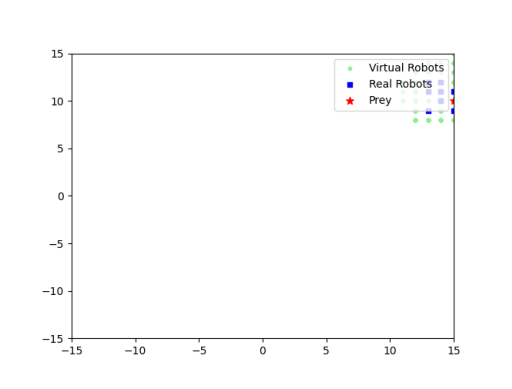

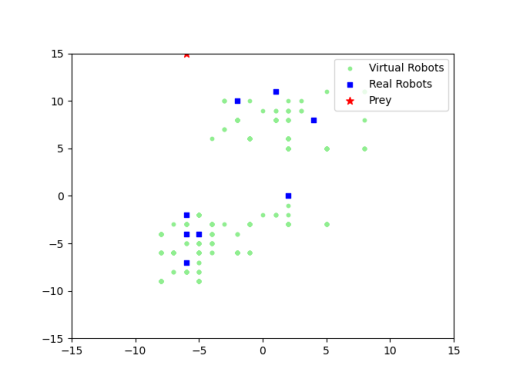

In [19]:
with open('records.txt', 'w', encoding='utf-8') as file:
    grid = 15
    for Ns in [8]:        
        bso_record = ccbso(Ns=Ns, Np=50, left_range=-grid, right_range=grid, vicinity=grid//2, time_lim=100)
        pso_record = ccpso(Ns=Ns, Np=50, left_range=-grid, right_range=grid, vicinity=grid//4, time_lim=100)
        file.write(f'Predators={Ns}, Grid={grid*2}\n')
        file.write(f'PSO Moves={pso_record}\n')
        file.write(f'BSO Moves={bso_record}\n')
        file.write('\n')